# BitTrack Project
## Send request and Get data

In [3]:
import requests
import csv
import json

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

# Time in UNIX format
month = 2629743
now = int(time.time())
start_time = now - 3*month
DATALENGTH = 500
ema_length = 50

url = f"http://api.coincap.io/v2/assets/bitcoin/history?interval=h1"
print(url)

# Request data from the API
response = requests.request("GET", url, headers={}, data={})
json_data = json.loads(response.text.encode('utf8'))
# print(json_data)
bitcoin_data = json_data["data"]

df = pd.DataFrame(bitcoin_data)
## Export data as a csv file
# df.to_csv('BTCUSD.csv', index=False)
print(df.sample)
# df.dtypes

# Filter only the columns we need
df = pd.DataFrame(bitcoin_data, columns=['time', 'priceUsd'])
# Get last 200 rows and REVERSE, newest price on top (index 0)
df = df[:-DATALENGTH-1:-1]
print(df.sample)

# Convert 'priceUsd' datatype to something numeric
df['priceUsd'] = pd.to_numeric(df['priceUsd'], errors='coerce', downcast='integer').fillna(0, downcast='infer')
df.dtypes
df.info()

http://api.coincap.io/v2/assets/bitcoin/history?interval=h1
<bound method NDFrame.sample of                    priceUsd           time          circulatingSupply  \
0    31637.3172601015895132  1653976800000  19054143.0000000000000000   
1    31476.9640692217228370  1653980400000  19054143.0000000000000000   
2    31544.8729379907179953  1653984000000  19054231.0000000000000000   
3    31618.8466454575317267  1653987600000  19054231.0000000000000000   
4    31517.9813698053008554  1653991200000  19054281.0000000000000000   
..                      ...            ...                        ...   
698  20043.0261977630054515  1656550800000  19080662.0000000000000000   
699  20022.4621817182351122  1656554400000  19080662.0000000000000000   
700  20069.6909524049403743  1656558000000  19080731.0000000000000000   
701  20065.5958338002822679  1656561600000  19080731.0000000000000000   
702  20028.8652621991691809  1656565200000  19080837.0000000000000000   

                         date  

In [4]:
# Check data 
prices = df['priceUsd']
print(prices)

702    20028.865262
701    20065.595834
700    20069.690952
699    20022.462182
698    20043.026198
           ...     
207    30194.717742
206    30165.512132
205    30216.902477
204    30383.846935
203    30316.347457
Name: priceUsd, Length: 500, dtype: float64


In [5]:
# Calculate and check last ema value 
count = 0
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

In [6]:
print("EMA50 H1:", ema(df['priceUsd'], count))

EMA50 H1: 20275.78110801686


In [7]:
# Process UNIX time to readable form
timeStamp =  df['time'].values.tolist()
timeStamp = [x / 1000 for x in timeStamp]

In [8]:
# Insert readable timeStamp column to 'df'
df['timeStamp'] = pd.to_datetime(timeStamp, unit='s')

In [9]:
# Check
df.sample

<bound method NDFrame.sample of               time      priceUsd           timeStamp
702  1656565200000  20028.865262 2022-06-30 05:00:00
701  1656561600000  20065.595834 2022-06-30 04:00:00
700  1656558000000  20069.690952 2022-06-30 03:00:00
699  1656554400000  20022.462182 2022-06-30 02:00:00
698  1656550800000  20043.026198 2022-06-30 01:00:00
..             ...           ...                 ...
207  1654722000000  30194.717742 2022-06-08 21:00:00
206  1654718400000  30165.512132 2022-06-08 20:00:00
205  1654714800000  30216.902477 2022-06-08 19:00:00
204  1654711200000  30383.846935 2022-06-08 18:00:00
203  1654707600000  30316.347457 2022-06-08 17:00:00

[500 rows x 3 columns]>

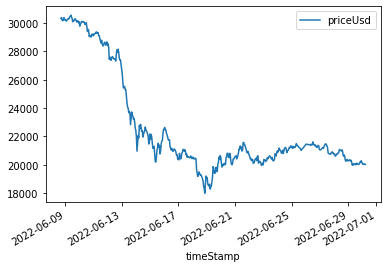

In [10]:
# Plot the data
df.plot(x ='timeStamp', y='priceUsd', kind = 'line')
plot.show()

## Calculate the possible EMA for each timeStamp
'possible' means timeStamp that have at lease 50 values before it. After that, we add EMA value along with the above figure.

In [11]:
short_df = df.head(DATALENGTH-ema_length)
short_df.reset_index()

,index,time,priceUsd,timeStamp
0,702,1656565200000,20028.865262,2022-06-30 05:00:00
1,701,1656561600000,20065.595834,2022-06-30 04:00:00
2,700,1656558000000,20069.690952,2022-06-30 03:00:00
3,699,1656554400000,20022.462182,2022-06-30 02:00:00
4,698,1656550800000,20043.026198,2022-06-30 01:00:00
...,...,...,...,...
445,257,1654902000000,29180.713206,2022-06-10 23:00:00
446,256,1654898400000,29213.042543,2022-06-10 22:00:00
447,255,1654894800000,29199.033716,2022-06-10 21:00:00
448,254,1654891200000,29006.363593,2022-06-10 20:00:00


In [12]:
short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))

/tmp/ipykernel_42532/2719915233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))


In [13]:
# short_df['N'] = np.arange(len(short_df))
short_df.insert(loc=0, column='N', value=np.arange(len(short_df)))

In [14]:
# Try modifying a value in EMA column
# short_df.loc[713,'EMA'] = 999999
# Try accessing short_df
print(short_df['EMA'].iloc[-1])

0.0


In [15]:
# Finalize 'ema' function to run in for loop
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

# Calculate ema values and replace them into the dataframe
for i in range(0, DATALENGTH-ema_length):
    count = 0
    # short_df.iloc[ ?,4 ] => 'EMA' column
    # df['priceUsd'].iloc[ i: ] => use dataFrame from newest to the last 51st row
    short_df.iloc[ i,4 ] = ema( df['priceUsd'].iloc[ i: ], count )


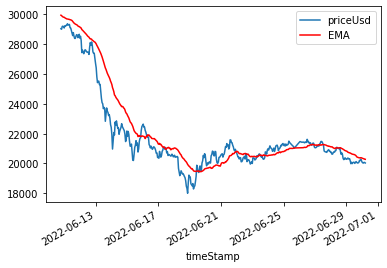

In [16]:
# Reference article https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
ax = plot.gca()
short_df.plot(kind='line',x='timeStamp',y='priceUsd', ax=ax)
short_df.plot(kind='line',x='timeStamp',y='EMA', color='red', ax=ax)
plot.show()

## Create a while loop to update price constantly

## Alarm when PRICE cross EMA

## Analyze profit/loss if trade base on EMA 

Strategy 1  
using data in the past 720 hours  
Long/Short when Price cross EMA50 in H1 timeframe, update each hour  
TP when +1000, move SL to entry  


Strategy 2  
using data in the past 720 hours  
with R:R=1:1, TP = SL = 5%  
TP 80% when reach target, move SL to entry


In [17]:
# check
df['timeStamp'].iloc[50]

Timestamp('2022-06-28 03:00:00')

In [18]:
balance = 1000
placed_order = 0
old_entry = 0

for i in reversed(range(0, DATALENGTH-ema_length-1)):
    count = 0
    old_price = df['priceUsd'].iloc[i+1]
    current_price = df['priceUsd'].iloc[i]
    timeStamp = df['timeStamp'].iloc[i]
    current_ema = ema( df['priceUsd'].iloc[i:], count )
    
    # TP if price moves 1000
    if (abs(current_price - old_entry) >= 1000):

        if (placed_order == 1):
            balance = balance * current_price / old_entry
            print(f'CLOSE BUY POSITION ' + '='*45 + \
              f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')

        elif (placed_order == -1):
            balance = balance * (2 - current_price / old_entry)
            print(f'CLOSE SELL POSITION ' + '='*45 + \
              f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')

        placed_order = 0

    # Price going up
    if (old_price <= current_ema <= current_price):
        # If placed SELL order, close that previous SELL order
        if (placed_order == -1):
            balance = balance * (2 - current_price / old_entry)
            print(f'CLOSE SELL POSITION ' + '='*45 + \
                f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')
            placed_order = 0
        # Place order if there's no position
        if (placed_order == 0):
            old_entry = current_price
            placed_order = 1
            print(f'BUY ' + '='*50 + \
                f'\nEntry: {old_entry}  \nBalance: {balance}\n')

    # Price going down
    elif (old_price >= current_ema >= current_price):
        # If placed BUY order, close that previous BUY order
        if (placed_order == 1):
            balance = balance * current_price / old_entry
            print(f'CLOSE BUY POSITION ' + '='*45 + \
                f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')
            placed_order = 0
        # Place order if there's no position
        if (placed_order == 0):
            old_entry = current_price
            placed_order = -1
            print(f'SELL ' + '='*50 + \
                f'\nEntry: {old_entry}  \nBalance: {balance}\n')

    print(f'i = {i}')
    print(f'timeStamp = {timeStamp}')
    print(f'price = {current_price}')
    print(f'ema = {current_ema}\n')


i = 448
timeStamp = 2022-06-10 20:00:00
price = 29006.36359323168
ema = 29921.802481827606

i = 447
timeStamp = 2022-06-10 21:00:00
price = 29199.033715828795
ema = 29871.756941100073

i = 446
timeStamp = 2022-06-10 22:00:00
price = 29213.04254312781
ema = 29839.244601277842

i = 445
timeStamp = 2022-06-10 23:00:00
price = 29180.713205668093
ema = 29817.216375481414

i = 444
timeStamp = 2022-06-11 00:00:00
price = 29091.295533506018
ema = 29812.31662530826

i = 443
timeStamp = 2022-06-11 01:00:00
price = 29244.341883353736
ema = 29780.00556279538

i = 442
timeStamp = 2022-06-11 02:00:00
price = 29209.38689804736
ema = 29744.01953423771

i = 441
timeStamp = 2022-06-11 03:00:00
price = 29271.52228820911
ema = 29727.558269050416

i = 440
timeStamp = 2022-06-11 04:00:00
price = 29274.657301167368
ema = 29699.232666255168

i = 439
timeStamp = 2022-06-11 05:00:00
price = 29378.591348567257
ema = 29693.122654629176

i = 438
timeStamp = 2022-06-11 06:00:00
price = 29292.918354461843
ema = 2968

#### Errors:
- Sell 2 consecutive times  
- i = 441 different prices  
#### Todos:
- Add B/S on the chart where order is placed
- TP1 is 80% when price moves xxx, TP2 the rest 20% is when price crosses EMA50 
- Create a Account class